# Homework 3
## ME 326: Collaborative Robotics
### Stanford University

In [1]:
%matplotlib inline
#for problem 1
import numpy as np
import math
import matplotlib.pyplot as plt #for plotting just like in matlab
from matplotlib import animation, rc #this will be used to play animations
# rc('text', usetex=True) #if you want to use latex in plot legends
#Additional pkgs: 
rc('animation', html='jshtml')
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

#for problem 2
import torch
import torch.nn as nn
from torch import optim
import random

#for problem 3
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader

## Problem 1: Gaussian Process for Regression

Gaussian Processes (GP) are one of the simplest yet powerful methods of regression for machine learning. It is a non-parametric representation, meaning that there are not parameters used in the underlying model. Machine learning as a whole is based on the concept of pattern recognition: *given similar input, similar output is expected*. The key question is what qualifies as *similar*. In a GP, similarity is defined using the concept of a Gaussian function $f(x|\bar{x},\sigma)$ (also known as a normal distribution), which for a single variable can be written as: 
$$f(x|\bar{x},\sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp{\left(-\frac{(x-\bar{x})^2}{2 \sigma^2}\right)}$$

For a GP, two points $x_1,x_2$ can be used to substitute $(x,\bar{x})$ above, and the score from the Gaussian is used to evaluate *similarity*. This is formally known as the *kernel* of the GP and is expressed formally as: 
$$\kappa(x_i,x_j)= \sigma^2 \exp\left(-\frac{(x_i - x_j)^2}{l_2}\right)$$

Note the explicit abstraction of $(\sigma^2,l_2)$ which serve as tuning variables for the shape of the Gaussian Kernel, by changing these values, the notion of *closeness* can be adapted to the particular scenario, and this is the main component that requires *engineering* by the programmer. 

Given these expressions for Kernel, the data can now be considered. The training data is required as this is a *supervised* method, and would include the input and corresponding labels $(x,y)_{\text{train}}$. The goal is to use the training data along with test inputs $x^*$ to find the corresponding test outputs $y^*$.

The output of the GP is the predicted output $y^*$ conditioned on training input, output and test inputs: 
$$GP(y^* | x,y,x^*)$$
as well as a variance that characterizes the models uncertainty for the test points, which comes from how close the test point is to the set of training points $V(x^*)$

### GP Learning Process
1. The first step is to establish your initial kernel parameters, these can be later adjusted based on performance to better represent your system
2. The first step is to take your training data $(x,y)$ and set some portion of it (randomly sampled) to confirm that your tuned kernel parameters work when you apply it to data (test points $x^*$) whose label you don't have access. (*note that the following steps apply to this **hold out set** in addition to true test points you want to evaluate*)
3. Generate training covariances with all training points $K_{i,j} = \kappa(x_i,x_j)$ (note this is a square matrix) and test-train covariances $K^*_{i,j} = \kappa(x^*_i,x_j)$, and test-test covariances $K^{**}_{i,j} = \kappa(x^*_i,x^*_j)$
4. Generate the information matrix (solving for this matrix is effectively training your matrix):
$$L = (K+\gamma I)^{-1}$$
where $\gamma$ is some very small number (e.g. 0.001) and $I$ is the identity matrix.
5. Solve for the test point outputs $y^*$ and model uncertainty at those test points $V(x^*)$ (diagonal of this square matrix)
$$y^* = K^* L y$$
$$V(x^*) = K^{**} - {K^{*}}^T L K^{*} $$

<div>
<img src="https://github.com/armlabstanford/armlabstanford.github.io/raw/master/figures/me326/homework3/GP_description.png" width="500"/>
</div>

### Your Code Goes Here:

In [2]:
def student_function_1(xp=0,xq=0):
    """
    Description: GP Kernel Function - defines Gaussian kernel function: k(xp,xq) = exp(-(0.5)(xp-xq).T(xp-xq))
    
    
    Parameters
    ----------
    xp : np.ndarray or np.matrix 
        first input point - could be scalar or vector
    xq : np.ndarray or np.matrix
        second input point - could be scalar or vector
        
    Returns
    -------
    kern : np.matrix
        kernal matrix output
    """
    #first check that size and dim are the same else print error and return 0
    kern = 0 #default kernel value
    if type(xp) != type(xq):
      #this is the case when you want to get a kernel vector or non-square type, but make them both the same type (e.g matrix)
      print("types are wrong")
    
    #Implement:
    if isinstance(xp, np.matrix) and isinstance(xq, np.matrix):
      if np.min(xp.shape) == 1 and np.min(xq.shape) == 1:
        #make sure they have the same orientation (e.g. both column vectors -> if xp.shape[0] == 1: xp = xp.T)
        if xp.shape[0] == 1: xp = xp.T
        if xq.shape[0] == 1: xq = xq.T
        #calculate the kernel (some iteration may be necessary for non-square kernel input)
        kern = np.zeros([np.max(xp.shape),np.max(xq.shape)])  #non-square kernel
        for idx in range(np.max(xp.shape)):
            for jdx in range(np.max(xq.shape)):
                diff = float(xp[idx, 0]) - float(xq[jdx, 0])
                kern[idx, jdx] = np.exp(-0.5 * diff**2)
            
      else:
        print("vectors (nx1) were not passed")
        #need a vector
    else:
      #this assumes xp, xq are both scalars
      kern = np.exp(-0.5 * (float(xp) - float(xq))**2)
    
    #Return the kernel
    kern = np.matrix(kern)
    return kern
    
    
def student_function_2(K_train,gamma,y_train):
    """
    Description: GP Information Matrix - decision vector: L = (K+s*I)^{-1} y_train
    
    Parameters
    ----------
    Ktrain : np.matrix
        Raw input 
    gamma : float
        (s) shown above, small scalar multiplied by identity
    y_train : np.matrix
        training point outputs
    Returns
    -------
    L_mat : np.matrix
        GP information matrix
    """
    n = K_train.shape[0]
    L_mat = np.linalg.inv(K_train + gamma * np.eye(n)) @ y_train
    return np.matrix(L_mat)

### Evaluation:

In [3]:
#Evaluation
class GPExample(object):
  """docstring for GPExample
    This is a simple script that demos the abilities of the GP on a simple 2D example of a sine curve  
  """
  def __init__(self, a=1,b=1,c=0,d=0, num_training_pts=20, training_data_span=[0,10]):
    self.x_train = np.linspace(training_data_span[0], training_data_span[1], num_training_pts)
    self.y_train = a*np.sin(b*self.x_train + c ) + d
    #turn these into matricies
    self.x_train = np.matrix(self.x_train).T  #these were lists, defaults to row vector, make coloumn
    self.y_train = np.matrix(self.y_train).T

    self.K_train = None  #covariance matrix for training data
    self.alpha_vect = None  #decision vector soley based on training data
    self.sigma = 1e-1  #this is to help when covariance is very small with inversion

  def kernel_function(self,xp=0,xq=0):
    #defines Gaussian kernel function: k(xp,xq) = exp(-(0.5)(xp-xq).T(xp-xq))
    #first check that size and dim are the same else print error and return 0
    kern = student_function_1(xp,xq)
    return kern

  def obtain_K_train(self):
    #obtain the training covariance
    self.K_train = self.kernel_function(self.x_train, self.x_train) #this uses the kernel to establish positional relationship between the training data points

  def obtain_alpha(self):
    #This is the decision vector: alpha = (K+s*I)^{-1} y_train
    K = self.K_train
    self.alpha_vect = student_function_2(K,self.sigma,self.y_train)

  def generate_test_points(self,num_test_pts=20,test_data_span=[0,9.5]):
    #generate test points, this can be reduced to a single test point if desired
    self.x_test = np.matrix(np.linspace(test_data_span[0], test_data_span[1], num_test_pts)).T

  def evaluate_test_points(self):
    #Evaluate the test points to find y_test, Ky_test (mean and variance with each test point)
    #1. find the kernel vector with the training data
    K_s = self.kernel_function(xp=self.x_train, xq=self.x_test)
    K_ss = self.kernel_function(xp=self.x_test, xq=self.x_test)
    #Check their dimensions
    #print("\nK_s shape:", K_s.shape, "\nK_ss shape:", K_ss.shape)
    #print("\nKs, ", K_s, "\n K_ss", K_ss, ", K_ss det: ", np.linalg.det(K_ss))
    #2. Find f = Ks^T*(K+s*I)^{-1} y
    self.y_test = K_s.T * self.alpha_vect
    #print("y_test", self.y_test)
    #3. Find V[f] (covariance): Kss - Ks^T (K + s*I)^{-1} Ks
    K = self.K_train
    #print("\nKss shape", K_ss.shape, " Ks shape", K_s.shape, "\ndet Kss", np.linalg.det(K_ss))
    self.cov_test = K_ss - K_s.T*np.linalg.inv(K + self.sigma*np.eye(np.max(K.shape)))*K_s
    #This too should have expected covariance properties
    cov_sym = self.cov_test - self.cov_test.T
    #print("cov_test det:", np.linalg.det(self.cov_test), " V^T-V max/min values:", np.max(cov_sym), np.min(cov_sym))

  def display_GP_output(self,num_training_pts=0):
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca()
    #Plot the training data
    train_data = ax.plot(self.x_train.T.tolist()[0], self.y_train.T.tolist()[0],label="training data")
    train_data_scatter = ax.scatter(self.x_train.T.tolist()[0], self.y_train.T.tolist()[0],label="training data scatter")
    #Plot the mean test data
    test_data_mean = ax.scatter(self.x_test.T.tolist()[0],self.y_test.T.tolist()[0],label="test data mean")
    #Plot the associated covariance with the test data, realize that the associated covariance with each point is the diagonal elements of V[f]
    Vtt = [self.cov_test[idx,idx] for idx in range(self.cov_test.shape[0])]
    x = self.x_test.T.tolist()[0]
    y = self.y_test.T.tolist()[0]
    upper = [y[idx]+Vtt[idx] for idx in range(len(y))]
    lower = [y[idx]-Vtt[idx] for idx in range(len(y))]
    test_data_mean_cov = ax.fill_between(x,lower,upper, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    ax.legend(fontsize=15)
    ax.set_xlabel('x',fontsize=40)
    ax.set_ylabel('$y=sin(x)$',fontsize=40)
    
    fig.suptitle("Number of training points: %s"%num_training_pts,fontsize=40)
    plt.show()
    

def Evaluation(num_training_points=40,a=1,b=1,c=0,d=0):
    #This evaluation script evalutes the GP approximation of sine curves y = a*sin(b*x + c) + d
    a = 1; b = 1; c = 0; d = 0;
    num_training_pts = num_training_points #How many training points do you want to select?
    data_span = [0,10]  #x in [xs,xf]
    #generate class object
    cls_obj = GPExample(a=a,b=b,c=c,d=d, num_training_pts=num_training_pts, training_data_span=data_span)
    #Use training data to make covariance matrix
    cls_obj.obtain_K_train()
    #Then find the decision vector alpha
    cls_obj.obtain_alpha()
    #Generate the testpoints (feel free to update the default params)
    cls_obj.generate_test_points(num_test_pts=60)
    #Evaluate the test points (their mean and covariance w.r.t. the training data)
    cls_obj.evaluate_test_points()
    #Print the output
    cls_obj.display_GP_output(num_training_pts=num_training_pts)
    plt.show()

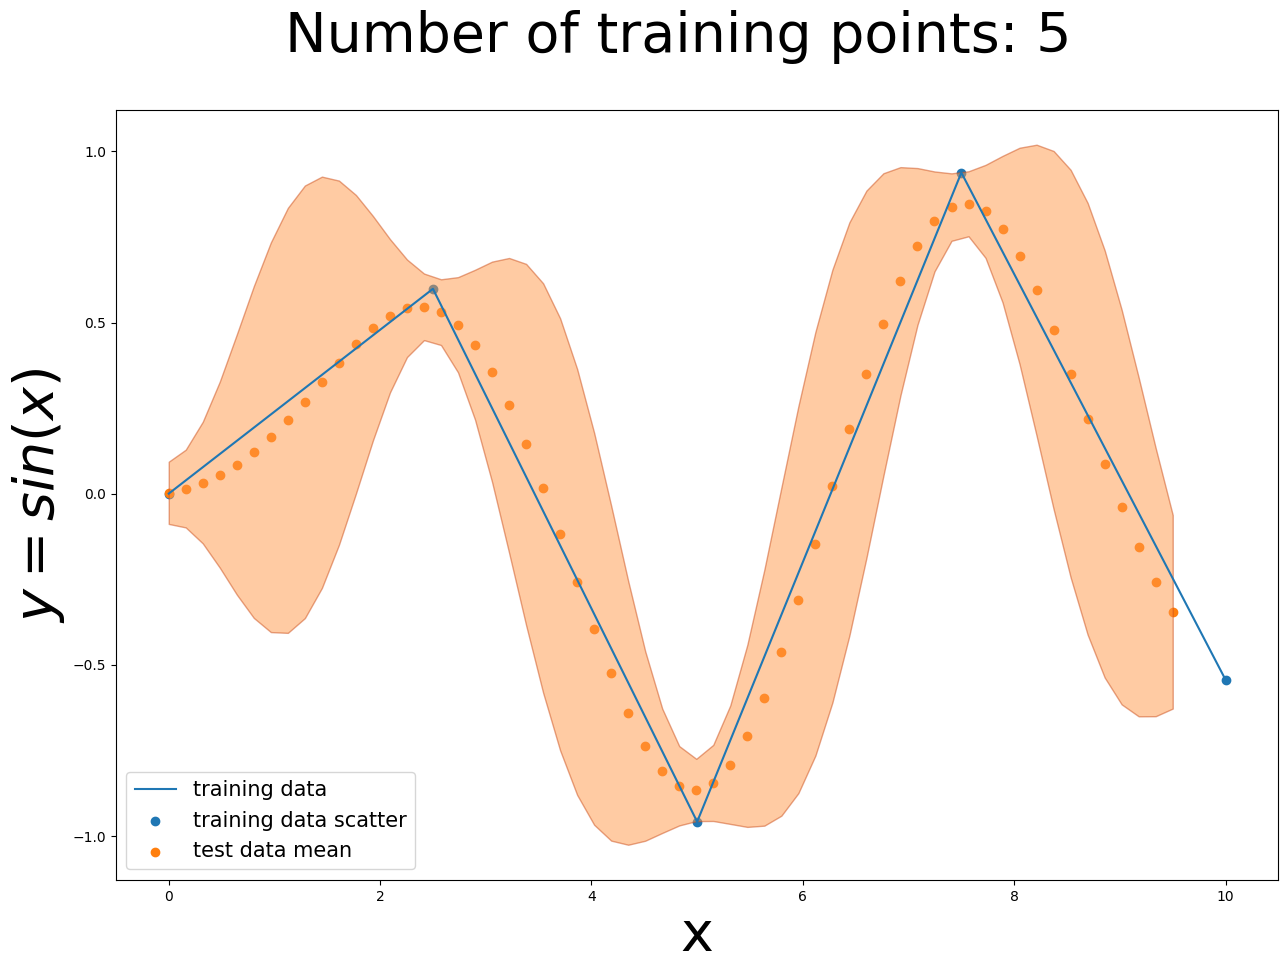

In [4]:
#show for 5points:
Evaluation(num_training_points=5)

In [ ]:
#show for 10points:
Evaluation(num_training_points=10)

In [ ]:
#show for 20points:
Evaluation(num_training_points=20)

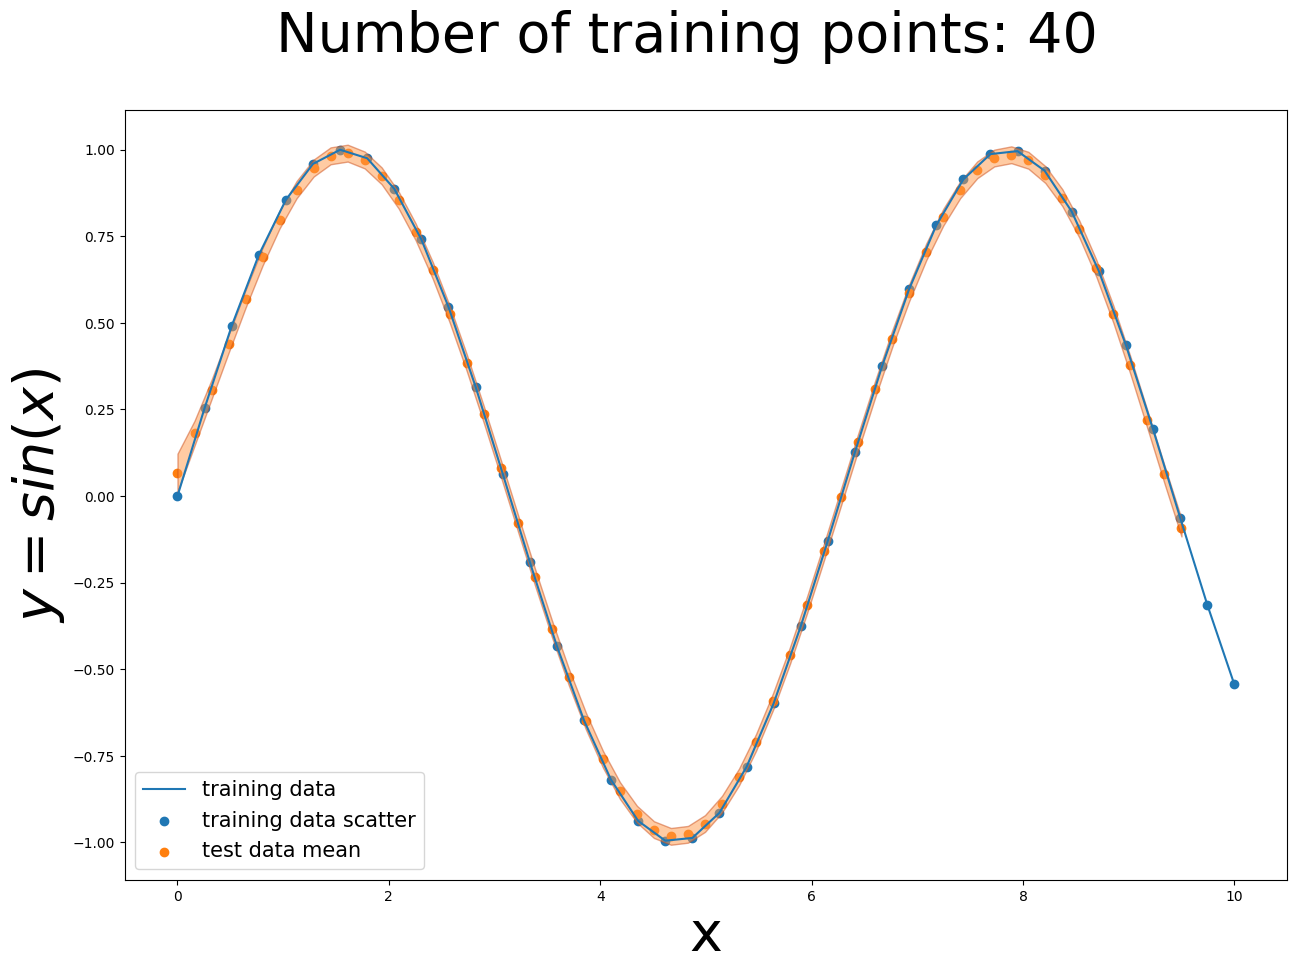

In [5]:
#show for 40points:
Evaluation(num_training_points=40)

## Problem 2: Multi-Layer Perceptrons for Regression

Neural Networks can serve well for approximating functions. A common network architecture is a Multi-Layer Perceptron (MLP) and consists of inputs mapped to nodes (activation functions), and the weights (and biases) of these connections are used collectively to train the network to produce the correct output for a given input. 

In order to train the MLP, a *loss* metric must be developed that penalizes the difference between the true output value $y$ and the estimated output value $\hat{y}$. For vector spaces, a common loss function is the Mean Squared Error (MSE) Loss function $MSE = \frac{1}{n}\sum_i^n (y_i-\hat{y}_i)^2$. The question becomes: *how should the weights and biases change in order to minimize the loss?*, and this is achieved through *backpropogation* which is the method of differentiating the error (taking a gradient) and determining how changing the weights and biases would effect the change in the output error (or loss). 

I recommend watching the following two lectures [Loss function and optimization](https://youtu.be/h7iBpEHGVNc) and [Introduction to Neural Networks](https://youtu.be/d14TUNcbn1k)

[![CS 231n - Loss Functions and Optimization](https://img.youtube.com/vi/h7iBpEHGVNc/0.jpg)](https://www.youtube.com/watch?v=h7iBpEHGVNc)

[![CS 231n - Introduction to Neural Networks](https://img.youtube.com/vi/d14TUNcbn1k/0.jpg)](https://www.youtube.com/watch?v=d14TUNcbn1k)


## Your Code
You will generate a model as shown in the figure below that will be capable of predicting dynamics of a two dimensional system: 
$$\dot{x}_{2\times 1} = f(x_{2 \times 1})$$
and you will see how the model is able to converge for a sufficient number of [epochs](https://en.wikipedia.org/wiki/Online_machine_learning)



<div>
<img src="https://github.com/armlabstanford/armlabstanford.github.io/raw/master/figures/me326/homework3/MLP_figure.png" width="700"/>
</div>

## Your Code Goes Here:

In [6]:
def student_function_3(cls_obj, lr = 0.003,epochs = 1000, show_training_loss=True):
    """
    Description: MLP Model training
    
    Parameters
    ----------
    cls_obj : class type Dynamical_System_dataset (defined below)
        Key functions: 
        data_batch = cls_obj.select_batch_training()
        state_inputs = data_batch['inputs']
        state_outputs = data_batch['outputs']

            Where:
            state_inputs : list of np.matrix
                input vector positions (x)
            state_outputs : list of np.matrix
                output vector velocities (dx) 
    lr: learning rate (for gradient descent)
    epochs: number of iterations to learn on
    
    Returns
    -------
    dyn_model : torch.nn.modules.container.Sequential (https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
        Trained MLP dynamic model (pytorch sequential type)
        Shape is shown above - 2 layers with nn.Linear connections that map 2 inputs to 10 hidden nodes which map to 10 hidden nodes 
        which map to 2 outputs: 2(in)->10->10-> 2(out)
        all activation functions are relu (https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
    """
    #This is the NN model description: (nn.linear sets up the weights, nn.Relu() specifies the activation functions)
    # 2(in)->10->10-> 2(out), all ReLU
    dyn_model = nn.Sequential(
        nn.Linear(2, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 2)
    )
    
    # make sure elements of dyn_model are type double()
    dyn_model.double()
    
    # Define the loss (criterion loss should be MSELoss)
    criterion = nn.MSELoss()
    
    # Optimizers require the parameters to optimize and a learning rate
    optimizer = optim.SGD(dyn_model.parameters(), lr=lr)
    
    #epochs are the number of learning trails
    for e in range(epochs):
        running_loss = 0
        #extract a batch of training points:
        data_batch = cls_obj.select_batch_training()
        state_inputs = data_batch['inputs']
        state_outputs = data_batch['outputs']
        for idx in range(len(state_inputs)):
            #iterate through the inputs and convert from numpy matrix to torch matrix
            curr_input = torch.from_numpy(state_inputs[idx].T)
            curr_output_label = torch.from_numpy(state_outputs[idx].T)
            #this loops, so make sure you zero your optimizer gradient
            optimizer.zero_grad()
            
            #Find the current output: output = dyn_model(input)
            output = dyn_model(curr_input)
            
            #Find your loss using the criterion: loss = criterion(y_estimated, y_true)
            loss = criterion(output, curr_output_label)
            
            #Perform back-propogation to train your model: loss.backward()
            loss.backward()
            #Increment your optimizer: optimizer.step()
            optimizer.step()
            #keep track of running loss: running_loss += loss.item()
            running_loss += loss.item()
        else:
            #this training loss is saying 'what is the average error on the samples in this batch in this round of training?'
            if show_training_loss: print(f"Training loss: {running_loss/len(state_inputs)}")

        
    return dyn_model,epochs

    

### Evaluation 

In [7]:
#In this block generate the dataset for a linear system
class Dynamical_System_dataset(object):
    def __init__(self,A=None):
        if type(A)==type(None):
            A = -np.matrix(np.eye(2))
        self.A = A
        self.training_data = {'inputs':[],'outputs':[]}
        
    def select_model(self,curr_input, model_type="nonlinear"):
        #make whatever model you would like here:
        if  model_type in "linear_1":
            A = np.matrix([[-1,0],[0,-1]])
            dx = A*curr_input
        elif model_type in "linear_2":
            A = np.matrix([[-1,0],[0,-1]])
            dx = A*curr_input            
        elif model_type in "nonlinear":
            #nonlinear model:
            x1 = curr_input.item(0)
            x2 = curr_input.item(1)
            dx = np.matrix([x2-0.5*x1 ,np.sin(x1)]).T
        else:
            print("please specify desired model or make a new one")
        return dx
    
    def generate_training_data(self,x1lim=[],x2lim=[],model_type="nonlinear"):
        x1_step = np.linspace(x1lim[0],x1lim[1],10)
        x2_step = np.linspace(x2lim[0],x2lim[1],10)
        input_list = []
        output_list = []
        for x1 in x1_step:
            for x2 in x2_step:
                curr_input = np.matrix([x1, x2]).T
                dx = self.select_model(curr_input,model_type=model_type)
                input_list.append(curr_input)
                output_list.append(dx)
        self.training_data["inputs"] = input_list
        self.training_data["outputs"] = output_list
        return self.training_data
    def select_batch_training(self,batch_size=10):
        list_len = len(self.training_data["inputs"])
        if batch_size > list_len:
            print("batch size too large")
            return []
        else:
            batch_idx = random.sample(range(list_len),batch_size)
        batch_inputs = [self.training_data["inputs"][idx] for idx in batch_idx]
        batch_outputs = [self.training_data["outputs"][idx] for idx in batch_idx]
        batch_train = {'inputs':batch_inputs,'outputs':batch_outputs}
        return batch_train

In [8]:
#evaluate the model once trained
def model_evaluation(dyn_model, cls_obj,epochs):
    #instantiate the model for evaluation
    dyn_model.eval()
    #Inputs
    X1 = []
    X2 = []
    #output vects from true dynamics
    Y1_train = []
    Y2_train = []
    #output vects from model
    Y1_test = []
    Y2_test = []

    training_data = cls_obj.training_data #collect all the training data for quiver plot
    for idx in range(len(training_data['inputs'])):
        X1.append(training_data['inputs'][idx].item(0))
        X2.append(training_data['inputs'][idx].item(1))
        Y1_train.append(training_data['outputs'][idx].item(0))
        Y2_train.append(training_data['outputs'][idx].item(1))
        #query the model
        curr_input = torch.from_numpy(training_data['inputs'][idx].T)
        curr_output = torch.from_numpy(training_data['outputs'][idx].T)
        model_output = dyn_model(curr_input)
        model_output_np = model_output.data.numpy()
        Y1_test.append(model_output_np.item(0))
        Y2_test.append(model_output_np.item(1))

    #Plot the real dynamics first:
    X1 = np.array(X1)
    X2 = np.array(X2)
    Y1_train = np.array(Y1_train)
    Y2_train = np.array(Y2_train)
    Y1_test = np.array(Y1_test)
    Y2_test = np.array(Y2_test)


    fig, ax = plt.subplots(figsize=(15,10))
    qtrain = ax.quiver(X1, X2, Y1_train, Y2_train,color='k')
    ax.quiverkey(qtrain, X=0.1, Y=1.1, U=5,
             label='Real Dynamics, length = 5', labelpos='S', fontproperties={'size':13})

    qtest = ax.quiver(X1, X2, Y1_test, Y2_test,color='r')

    ax.quiverkey(qtest, X=0.9, Y=1.1, U=5,
             label='Learned Dynamics, length = 5', labelpos='S', fontproperties={'size':13})

    ax.set_xlabel('$x_1$',fontsize=40)
    ax.set_ylabel('$x_2$',fontsize=40)
    fig.suptitle("Learning iterations (epoch): %s"%epochs,fontsize=25)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

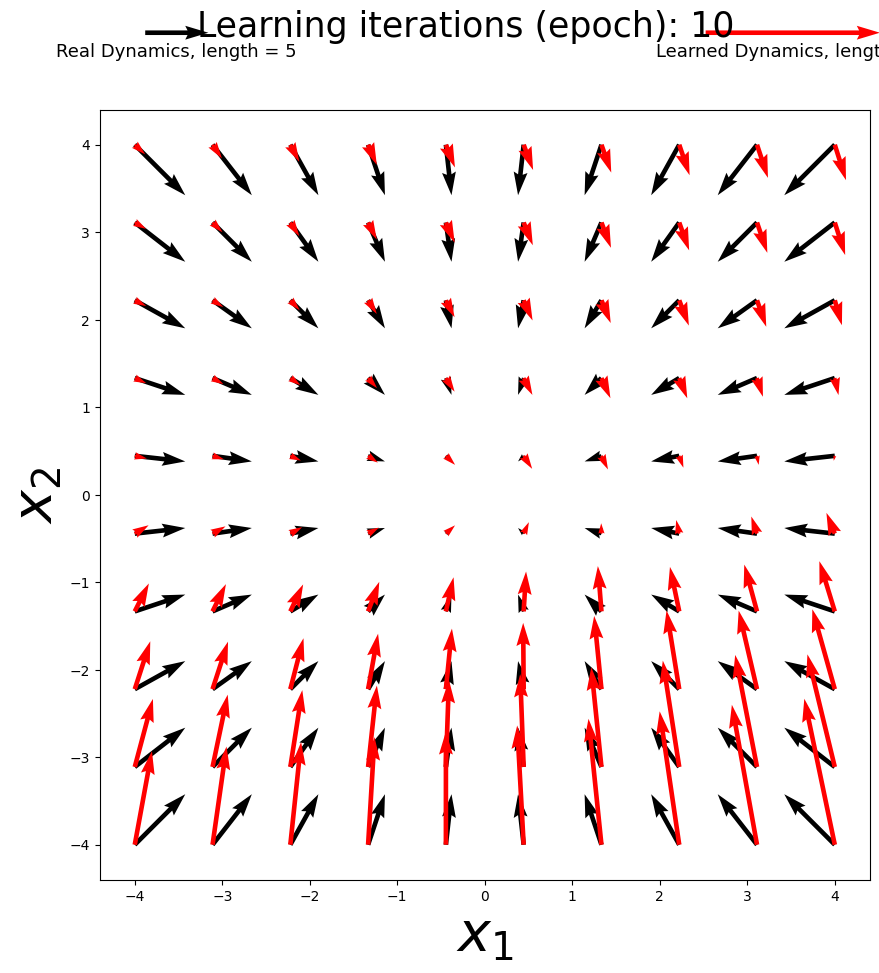

In [15]:
#Now set up to train the model:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4],model_type="linear_1")
dyn_model,epochs = student_function_3(cls_obj, show_training_loss=False, epochs=10)
# Now evaluate the model
model_evaluation(dyn_model, cls_obj,epochs)

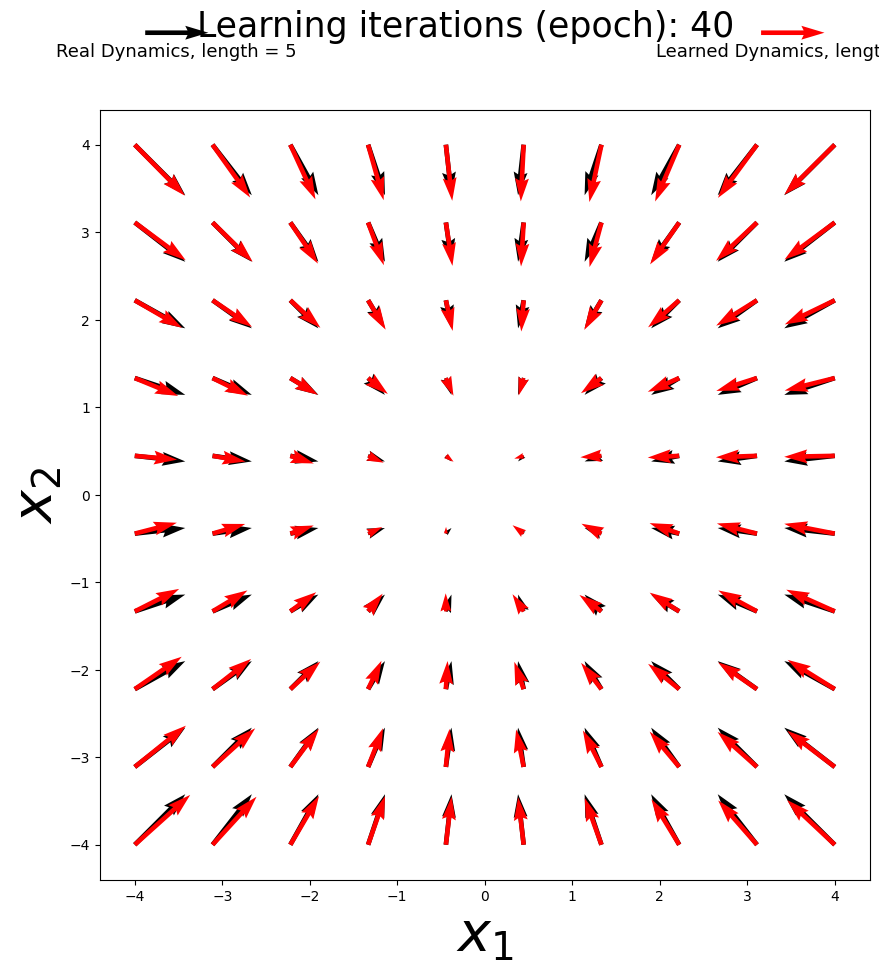

In [11]:
#Now set up to train the model:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4],model_type="linear_1")
dyn_model,epochs = student_function_3(cls_obj, show_training_loss=False, epochs=40)
# Now evaluate the model
model_evaluation(dyn_model, cls_obj,epochs)

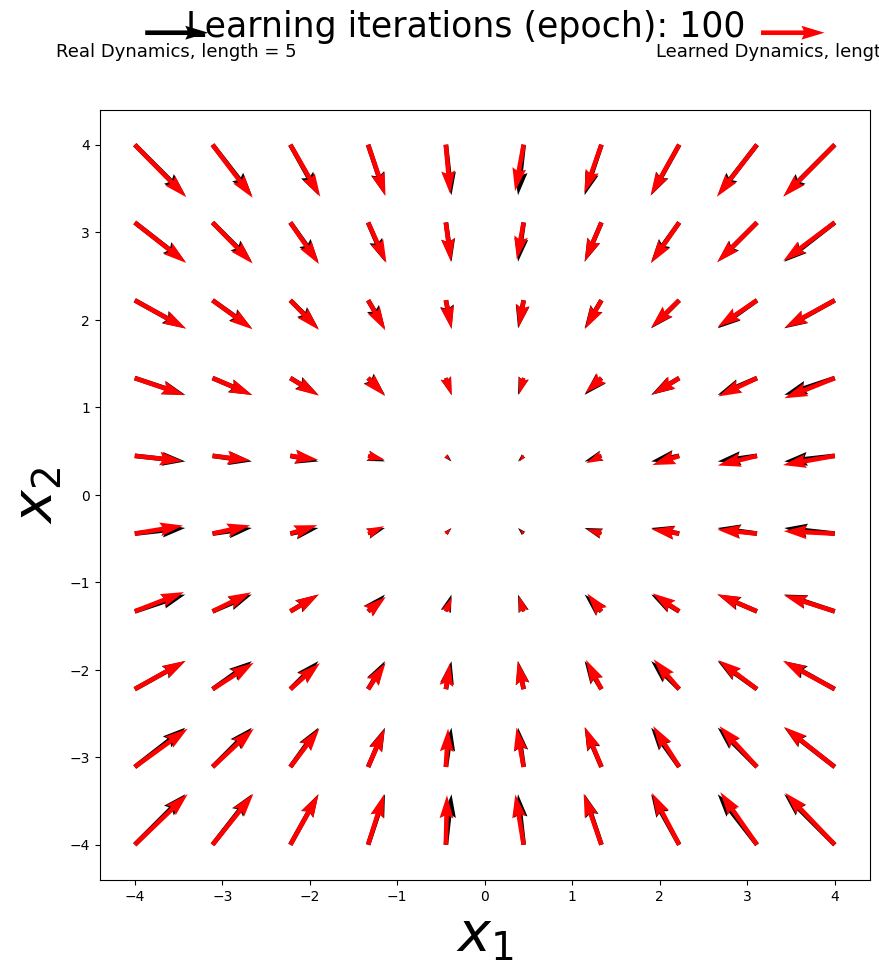

In [12]:
#Now set up to train the model:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4],model_type="linear_1")
dyn_model,epochs = student_function_3(cls_obj, show_training_loss=False, epochs=100)
# Now evaluate the model
model_evaluation(dyn_model, cls_obj,epochs)

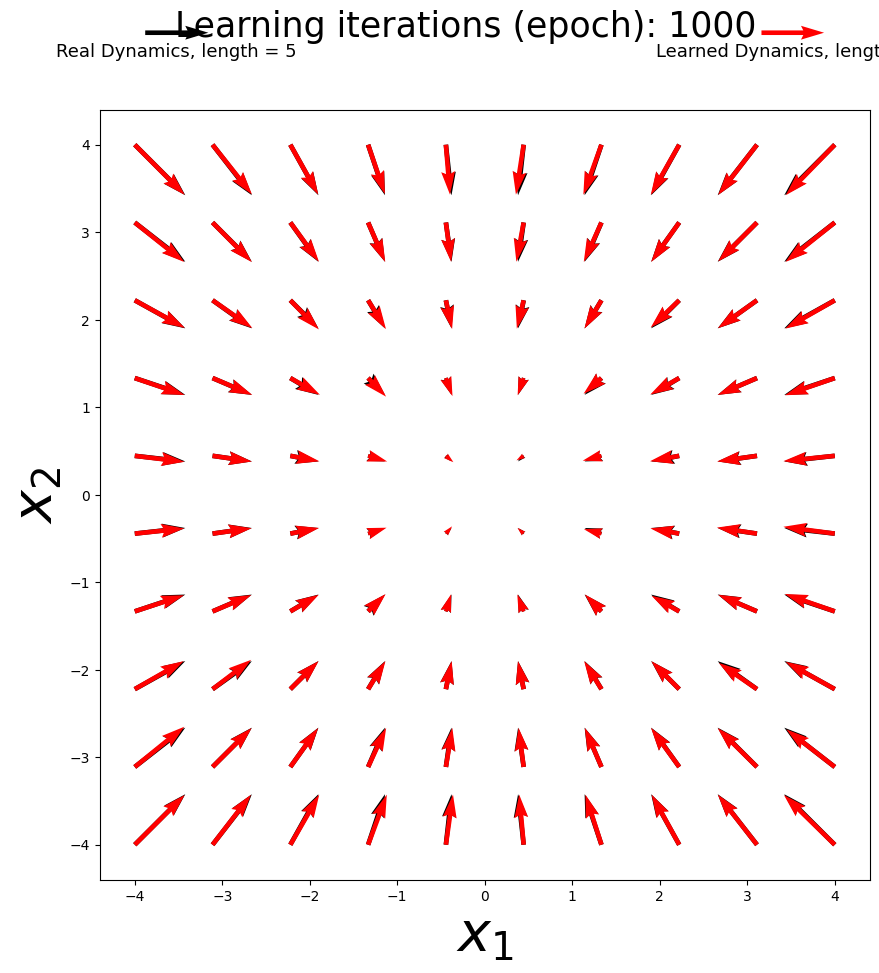

In [13]:
#Now set up to train the model:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4],model_type="linear_1")
dyn_model,epochs = student_function_3(cls_obj, show_training_loss=False, epochs=1000)
# Now evaluate the model
model_evaluation(dyn_model, cls_obj,epochs)

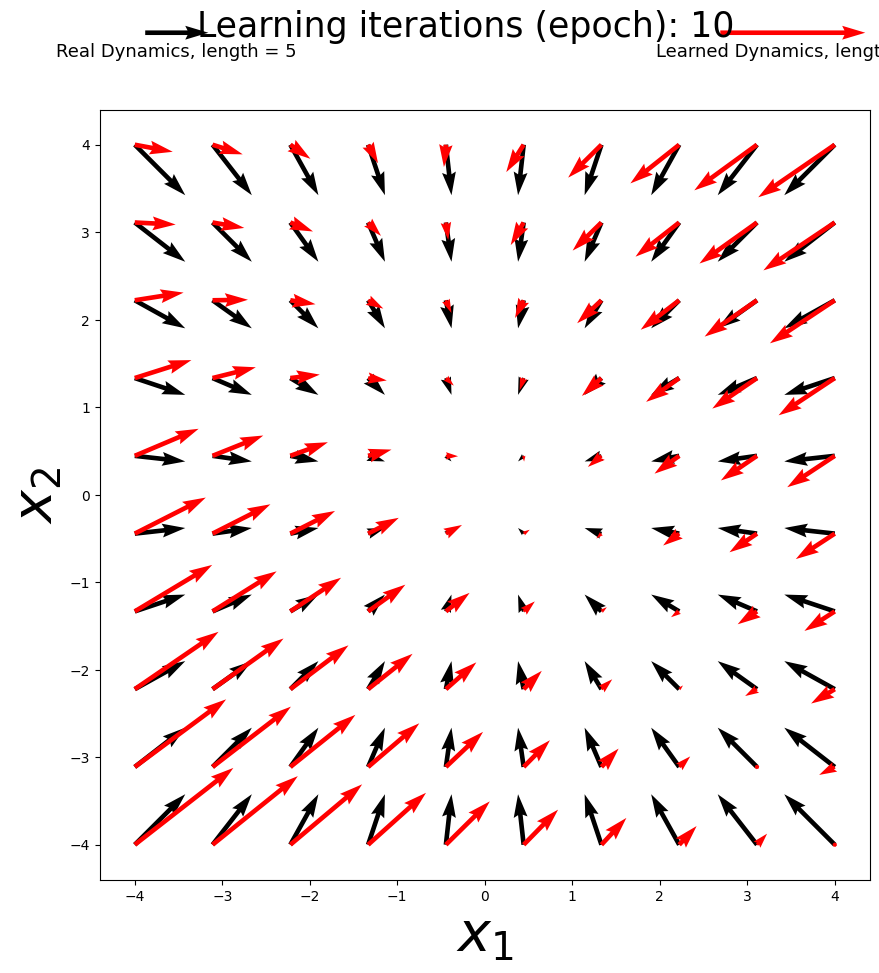

In [16]:
#Now set up to train the model:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4],model_type="linear_2")
dyn_model,epochs = student_function_3(cls_obj, show_training_loss=False,epochs=10)
# Now evaluate the model
model_evaluation(dyn_model, cls_obj,epochs)

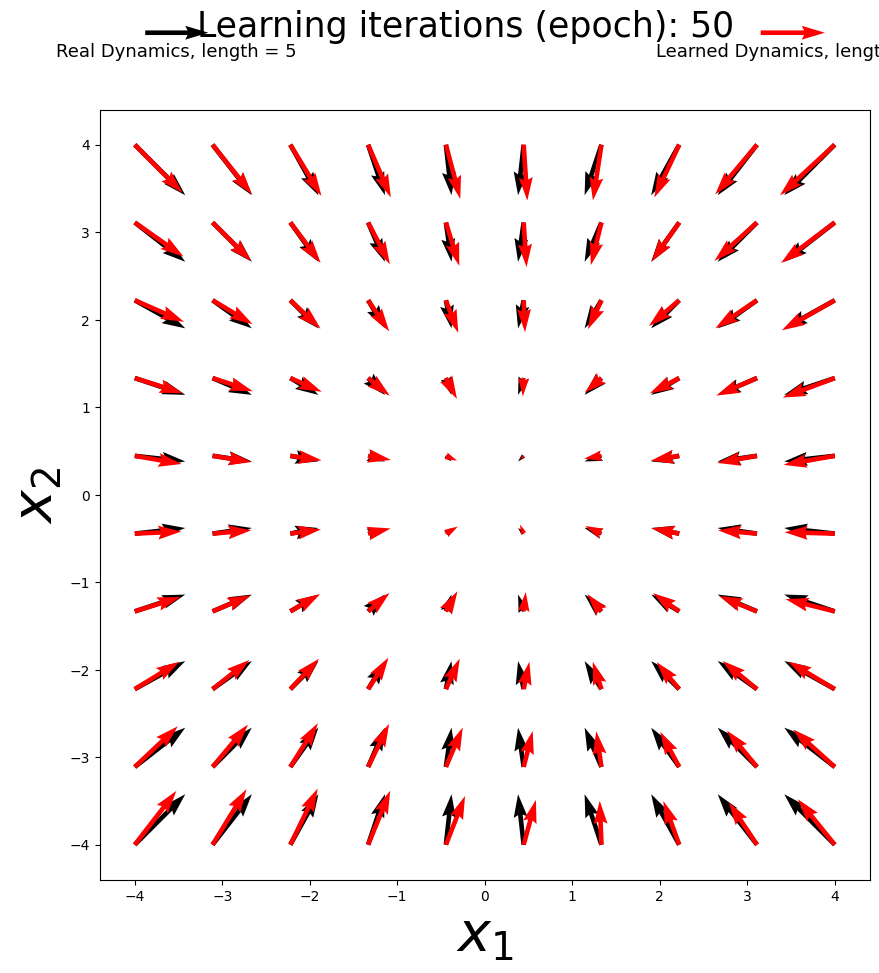

In [17]:
#Now set up to train the model:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4],model_type="linear_2")
dyn_model,epochs = student_function_3(cls_obj, show_training_loss=False,epochs=50)
# Now evaluate the model
model_evaluation(dyn_model, cls_obj,epochs)

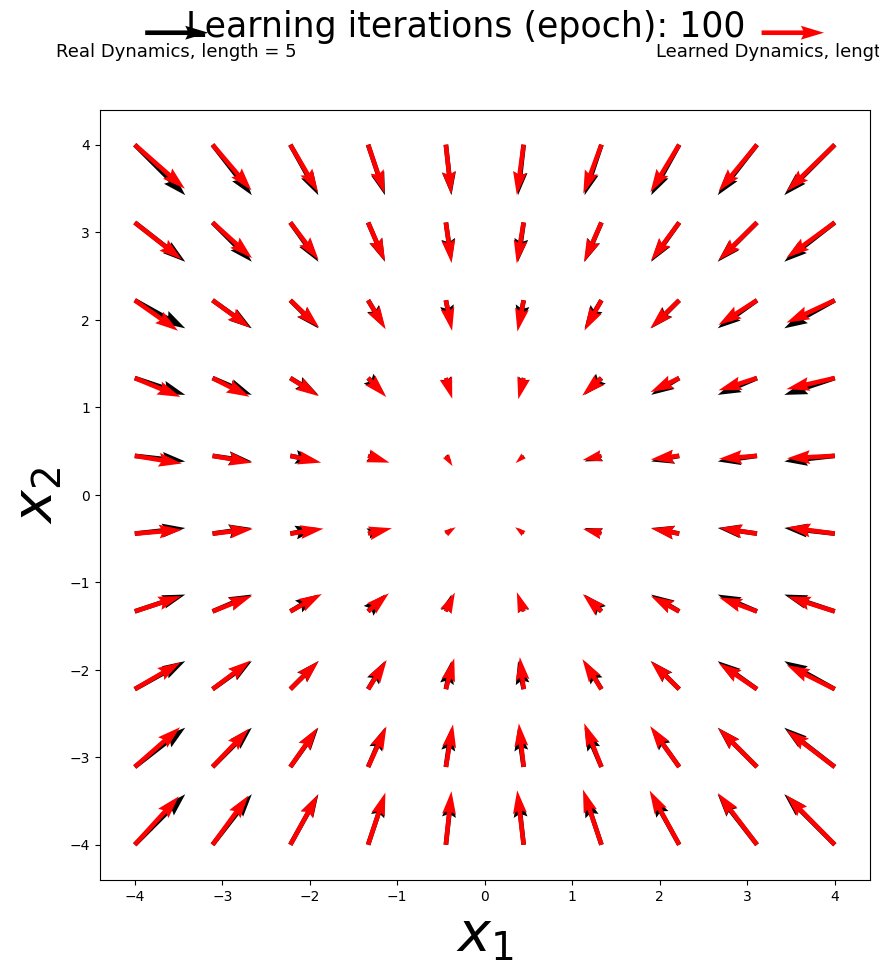

In [18]:
#Now set up to train the model:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4],model_type="linear_2")
dyn_model,epochs = student_function_3(cls_obj, show_training_loss=False,epochs=100)
# Now evaluate the model
model_evaluation(dyn_model, cls_obj,epochs)

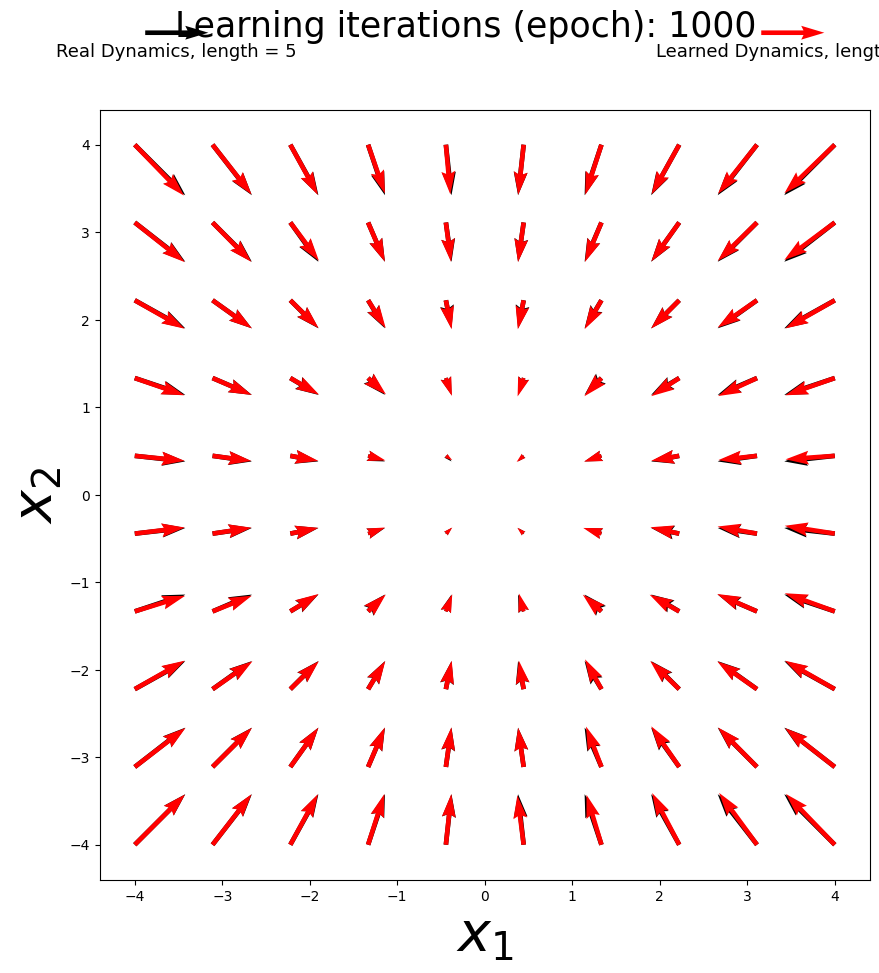

In [19]:
#Now set up to train the model:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4],model_type="linear_2")
dyn_model,epochs = student_function_3(cls_obj, show_training_loss=False,epochs=1000)
# Now evaluate the model
model_evaluation(dyn_model, cls_obj,epochs)

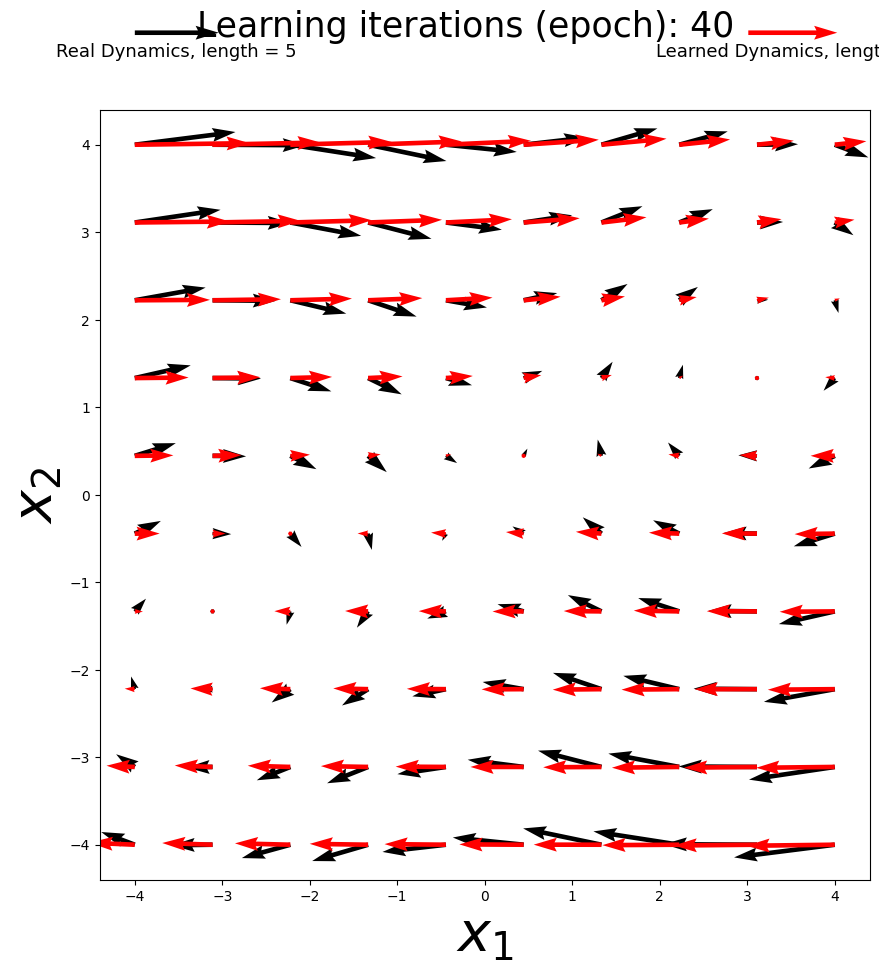

In [20]:
#Now set up to train the model:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4],model_type="nonlinear")
dyn_model,epochs = student_function_3(cls_obj, show_training_loss=False,epochs=40)
# Now evaluate the model
model_evaluation(dyn_model, cls_obj,epochs)

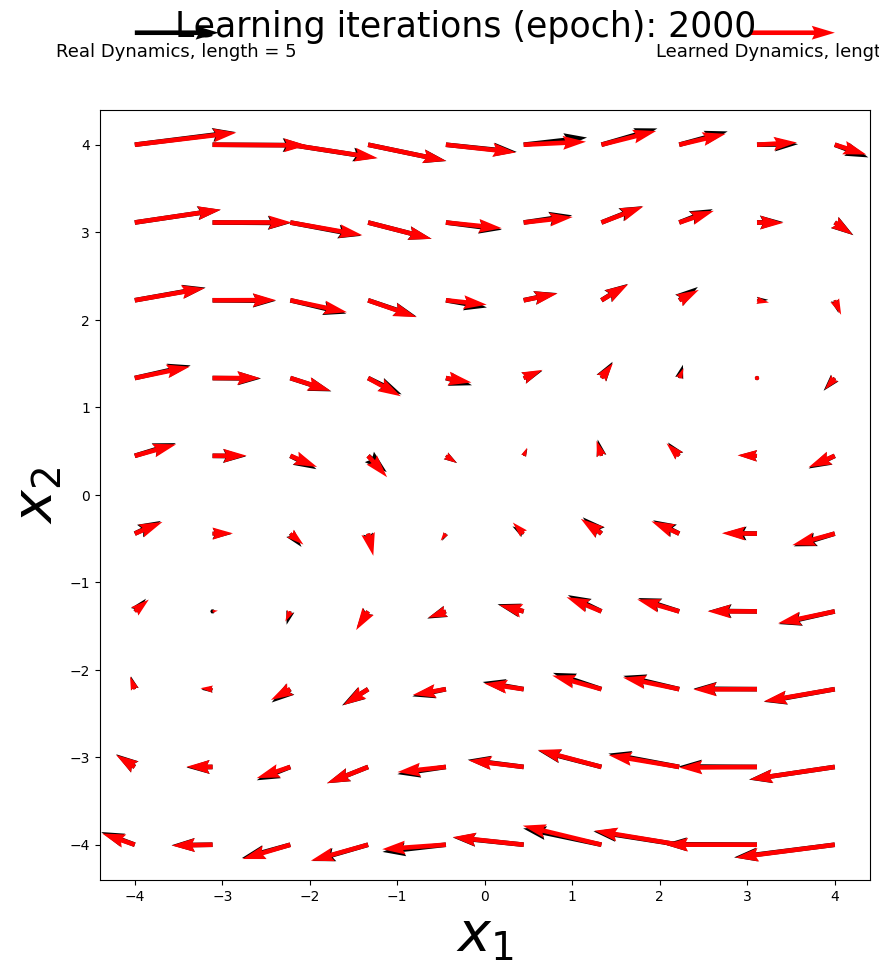

In [21]:
#Now set up to train the model:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4],model_type="nonlinear")
dyn_model,epochs = student_function_3(cls_obj, show_training_loss=False,epochs=2000)
# Now evaluate the model
model_evaluation(dyn_model, cls_obj,epochs)

## Problem 3: Neural Networks for Image Classification

In this problem, you will implement neural networks for classifying handwritten digits using the MNIST dataset. The MNIST dataset contains 60,000 training images and 10,000 test images of handwritten digits (0-9), each of size $28 \times 28$ pixels.

You will:
1. Build a simple Multi-Layer Perceptron (MLP)
2. Use a Convolutional Neural Network (ResNet18)
3. Experiment with different optimizers, learning rates, and batch sizes

### Classification Loss Function

For classification tasks, we use the **cross-entropy loss** instead of MSE:
$$\mathcal{L}_{CE} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)$$

where $C$ is the number of classes (10 for MNIST), $y_i$ is the true label (one-hot encoded), and $\hat{y}_i$ is the predicted probability from the **softmax** function:
$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$$

In PyTorch, `nn.CrossEntropyLoss()` combines softmax and cross-entropy for numerical stability.

### Part A: Data Loading

The following code loads the MNIST dataset and creates DataLoaders with configurable batch sizes.

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.19MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 105kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 888kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.59MB/s]


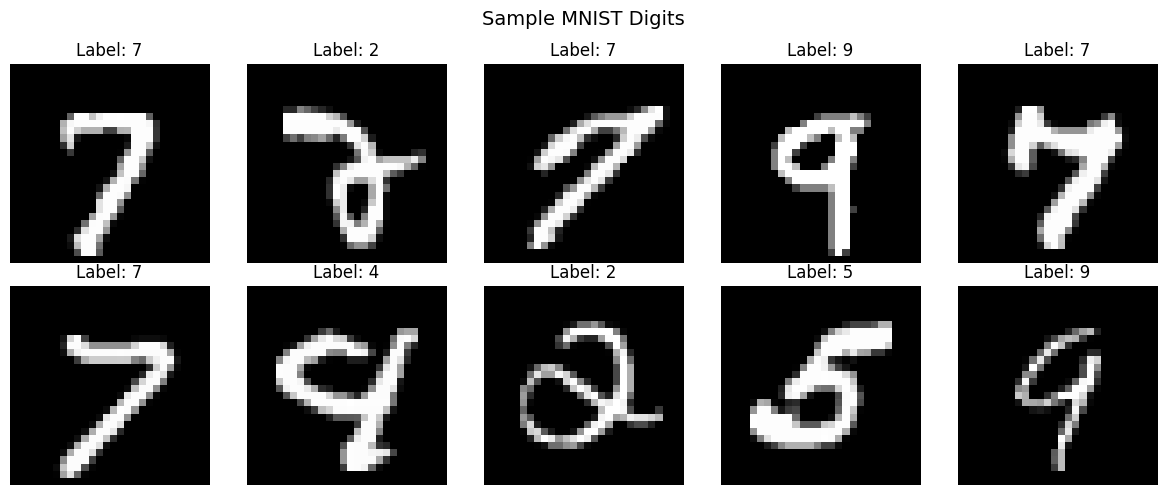

In [22]:
# Data loading utilities for MNIST
def load_mnist_data(batch_size=64):
    """
    Load MNIST dataset with specified batch size.
    
    Parameters
    ----------
    batch_size : int
        Number of samples per batch
        
    Returns
    -------
    train_loader : DataLoader
        Training data loader
    test_loader : DataLoader
        Test data loader
    """
    # Define transforms: convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])
    
    # Download and load training data
    train_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform
    )
    
    # Download and load test data
    test_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Visualize some sample digits
def show_sample_digits(train_loader):
    """Display a grid of sample digits from the dataset."""
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.suptitle('Sample MNIST Digits', fontsize=14)
    plt.tight_layout()
    plt.show()

# Load data and show samples
train_loader, test_loader = load_mnist_data(batch_size=64)
show_sample_digits(train_loader)

### Part B: Multi-Layer Perceptron (MLP)

Build an MLP that flattens the $28 \times 28$ image into a 784-dimensional vector and passes it through fully-connected layers:
$$784 \rightarrow 256 \rightarrow 128 \rightarrow 10$$

Each hidden layer uses ReLU activation, which is a go-to for smaller models. 

In [23]:
def student_function_4():
    """
    Description: Build MLP for MNIST classification
    
    The MLP should have the following architecture:
    - Flatten layer (28x28 -> 784)
    - Linear layer: 784 -> 256 with ReLU activation
    - Linear layer: 256 -> 128 with ReLU activation  
    - Linear layer: 128 -> 10 (output logits for 10 classes)
    
    Returns
    -------
    model : nn.Sequential
        MLP model for MNIST classification
    """
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    
    return model

In [24]:
def student_function_5(model, train_loader, optimizer, criterion, device, epochs=5):
    """
    Description: Training loop for neural network
    
    Parameters
    ----------
    model : nn.Module
        Neural network model to train
    train_loader : DataLoader
        Training data loader
    optimizer : torch.optim.Optimizer
        Optimizer (SGD, Adam, or RMSprop)
    criterion : nn.Module
        Loss function (CrossEntropyLoss)
    device : torch.device
        Device to train on (cpu or cuda)
    epochs : int
        Number of training epochs
        
    Returns
    -------
    loss_history : list
        Average loss per epoch
    """
    model.train()
    loss_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # 1. Zero the gradients
            optimizer.zero_grad()
            
            # 2. Forward pass
            outputs = model(images)
            
            # 3. Compute loss 
            loss = criterion(outputs, labels)
            
            # 4. Backward pass 
            loss.backward()
            
            # 5. Update weights
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return loss_history

### Part C: Convolutional Neural Network (ResNet18)

ResNet18 is a deep convolutional neural network with residual (skip) connections. 

The **cynics** will tell you ResNet is quite overrated. But these cynics have probably never used a real robot. In general, for in-the-wild robotics, a ResNet can get you pretty far with little data. I recommend to use a vision transform from SCRATCH if you have a massive amount of data; otherwise, use a ResNet or a vision foundation model with legit weights, like DINOv3.

For ResNet, you will modify it to work with MNIST:
- Change the first convolutional layer to accept 1-channel grayscale images (instead of 3-channel RGB)
- Change the final fully-connected layer to output 10 classes (instead of 1000 for ImageNet)as 

In [25]:
def student_function_6():
    """
    Description: Modify ResNet18 for MNIST classification
    
    You need to modify two parts of the pretrained ResNet18:
    1. Change conv1 to accept 1-channel input instead of 3-channel
       - Original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
       - Modified: nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    2. Change the final fc layer to output 10 classes instead of 1000
       - Use model.fc.in_features to get the input size
       - Replace with nn.Linear(in_features, 10)
    
    Returns
    -------
    model : torchvision.models.ResNet
        Modified ResNet18 model for MNIST
    """
    # Load ResNet18 without pretrained weights (weights=None for newer torchvision)
    model = models.resnet18(weights=None)
    
    # 1. Modify conv1 for 1-channel input
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # 2. Modify fc layer for 10-class output  
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 10)
    
    return model

### Part D: Hyperparameter Experimentation

You will experiment with different optimizers to understand their impact on training:
- **SGD** (Stochastic Gradient Descent): Basic optimizer, may need momentum for good performance
- **Adam**: Adaptive learning rate with momentum, often works well out-of-the-box
- **RMSprop**: Adaptive learning rate, good for recurrent networks and non-stationary objectives

In [26]:
def student_function_7(model_params, optimizer_name, lr):
    """
    Description: Create optimizer by name
    
    Parameters
    ----------
    model_params : generator
        Model parameters from model.parameters()
    optimizer_name : str
        Name of optimizer: 'SGD', 'Adam', or 'RMSprop'
    lr : float
        Learning rate
        
    Returns
    -------
    optimizer : torch.optim.Optimizer
        Configured optimizer
    """
    if optimizer_name == 'SGD':
        return optim.SGD(model_params, lr=lr)
    elif optimizer_name == 'Adam':
        return optim.Adam(model_params, lr=lr)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model_params, lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

### Evaluation

The following cells provide utility functions for computing accuracy and running experiments.

In [27]:
# Utility functions for evaluation
def compute_accuracy(model, test_loader, device):
    """Compute accuracy on test set."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def run_experiment(model_fn, train_loader, test_loader, optimizer_name, lr, device, epochs=5):
    """
    Run a single training experiment.
    
    Parameters
    ----------
    model_fn : callable
        Function that returns a new model instance
    train_loader : DataLoader
        Training data
    test_loader : DataLoader
        Test data
    optimizer_name : str
        Optimizer name ('SGD', 'Adam', 'RMSprop')
    lr : float
        Learning rate
    device : torch.device
        Device to use
    epochs : int
        Number of epochs
        
    Returns
    -------
    dict with 'loss_history', 'accuracy', 'model'
    """
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = student_function_7(model.parameters(), optimizer_name, lr)
    
    loss_history = student_function_5(model, train_loader, optimizer, criterion, device, epochs)
    accuracy = compute_accuracy(model, test_loader, device)
    
    return {
        'loss_history': loss_history,
        'accuracy': accuracy,
        'model': model
    }

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Run MLP Experiments

Test the MLP with different optimizers and learning rates.

In [28]:
# Run MLP experiments with different hyperparameters
optimizers = ['SGD', 'Adam', 'RMSprop']
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [1, 8, 16, 32, 64, 128]

# Store results
mlp_results = {}

# Run experiments (using default batch_size=64 for optimizer/lr comparison)
print("Running MLP experiments...")
for opt_name in optimizers:
    for lr in learning_rates:
        print(f"\n--- MLP with {opt_name}, lr={lr} ---")
        train_loader, test_loader = load_mnist_data(batch_size=64)
        result = run_experiment(student_function_4, train_loader, test_loader, 
                               opt_name, lr, device, epochs=5)
        mlp_results[(opt_name, lr)] = result
        print(f"Test Accuracy: {result['accuracy']:.2f}%")

Running MLP experiments...

--- MLP with SGD, lr=0.001 ---
Epoch 1/5, Loss: 2.1472
Epoch 2/5, Loss: 1.5310
Epoch 3/5, Loss: 0.9430
Epoch 4/5, Loss: 0.6746
Epoch 5/5, Loss: 0.5437
Test Accuracy: 87.42%

--- MLP with SGD, lr=0.01 ---
Epoch 1/5, Loss: 0.8018
Epoch 2/5, Loss: 0.3046
Epoch 3/5, Loss: 0.2481
Epoch 4/5, Loss: 0.2104
Epoch 5/5, Loss: 0.1821
Test Accuracy: 95.05%

--- MLP with SGD, lr=0.1 ---
Epoch 1/5, Loss: 0.2841
Epoch 2/5, Loss: 0.1026
Epoch 3/5, Loss: 0.0686
Epoch 4/5, Loss: 0.0492
Epoch 5/5, Loss: 0.0360
Test Accuracy: 94.44%

--- MLP with Adam, lr=0.001 ---
Epoch 1/5, Loss: 0.2297
Epoch 2/5, Loss: 0.0928
Epoch 3/5, Loss: 0.0647
Epoch 4/5, Loss: 0.0500
Epoch 5/5, Loss: 0.0394
Test Accuracy: 97.61%

--- MLP with Adam, lr=0.01 ---
Epoch 1/5, Loss: 0.2973
Epoch 2/5, Loss: 0.2040
Epoch 3/5, Loss: 0.1702
Epoch 4/5, Loss: 0.1602
Epoch 5/5, Loss: 0.1488
Test Accuracy: 95.90%

--- MLP with Adam, lr=0.1 ---
Epoch 1/5, Loss: 2.6373
Epoch 2/5, Loss: 2.0533
Epoch 3/5, Loss: 2.0747
Ep

### Run ResNet18 Experiments

Test ResNet18 with different optimizers and learning rates.

In [29]:
# Run ResNet18 experiments with different hyperparameters
resnet_results = {}

print("Running ResNet18 experiments...")
for opt_name in optimizers:
    for lr in learning_rates:
        print(f"\n--- ResNet18 with {opt_name}, lr={lr} ---")
        train_loader, test_loader = load_mnist_data(batch_size=64)
        result = run_experiment(student_function_6, train_loader, test_loader,
                               opt_name, lr, device, epochs=5)
        resnet_results[(opt_name, lr)] = result
        print(f"Test Accuracy: {result['accuracy']:.2f}%")

Running ResNet18 experiments...

--- ResNet18 with SGD, lr=0.001 ---
Epoch 1/5, Loss: 0.5480
Epoch 2/5, Loss: 0.1614
Epoch 3/5, Loss: 0.1084
Epoch 4/5, Loss: 0.0831
Epoch 5/5, Loss: 0.0669
Test Accuracy: 97.90%

--- ResNet18 with SGD, lr=0.01 ---
Epoch 1/5, Loss: 0.1629


KeyboardInterrupt: 

### Batch Size Experiments

Test the effect of different batch sizes on training.

In [ ]:
# Test different batch sizes with Adam optimizer (usually best default)
batch_size_results = {}

print("Running batch size experiments with MLP and Adam optimizer...")
for bs in batch_sizes:
    print(f"\n--- Batch size: {bs} ---")
    train_loader, test_loader = load_mnist_data(batch_size=bs)
    result = run_experiment(student_function_4, train_loader, test_loader,
                           'Adam', 0.001, device, epochs=5)
    batch_size_results[bs] = result
    print(f"Test Accuracy: {result['accuracy']:.2f}%")

### Comparison Plots

Visualize the results to compare different configurations.

In [ ]:
# Plot 1: Loss curves for MLP with different optimizers
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, opt_name in enumerate(optimizers):
    ax = axes[idx]
    for lr in learning_rates:
        if (opt_name, lr) in mlp_results:
            loss_hist = mlp_results[(opt_name, lr)]['loss_history']
            ax.plot(range(1, len(loss_hist)+1), loss_hist, label=f'lr={lr}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'MLP - {opt_name}')
    ax.legend()
    ax.grid(True)
plt.suptitle('MLP Training Loss by Optimizer and Learning Rate', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 2: Loss curves for ResNet18 with different optimizers
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, opt_name in enumerate(optimizers):
    ax = axes[idx]
    for lr in learning_rates:
        if (opt_name, lr) in resnet_results:
            loss_hist = resnet_results[(opt_name, lr)]['loss_history']
            ax.plot(range(1, len(loss_hist)+1), loss_hist, label=f'lr={lr}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'ResNet18 - {opt_name}')
    ax.legend()
    ax.grid(True)
plt.suptitle('ResNet18 Training Loss by Optimizer and Learning Rate', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Plot 3: Accuracy comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MLP accuracies
mlp_accs = []
labels = []
for opt_name in optimizers:
    for lr in learning_rates:
        if (opt_name, lr) in mlp_results:
            mlp_accs.append(mlp_results[(opt_name, lr)]['accuracy'])
            labels.append(f'{opt_name}\nlr={lr}')

axes[0].bar(range(len(mlp_accs)), mlp_accs, color='steelblue')
axes[0].set_xticks(range(len(mlp_accs)))
axes[0].set_xticklabels(labels, rotation=45, ha='right')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('MLP Test Accuracy')
axes[0].set_ylim([0, 100])
axes[0].grid(True, axis='y')

# ResNet accuracies
resnet_accs = []
for opt_name in optimizers:
    for lr in learning_rates:
        if (opt_name, lr) in resnet_results:
            resnet_accs.append(resnet_results[(opt_name, lr)]['accuracy'])

axes[1].bar(range(len(resnet_accs)), resnet_accs, color='darkorange')
axes[1].set_xticks(range(len(resnet_accs)))
axes[1].set_xticklabels(labels, rotation=45, ha='right')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('ResNet18 Test Accuracy')
axes[1].set_ylim([0, 100])
axes[1].grid(True, axis='y')

plt.suptitle('Test Accuracy Comparison', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Plot 4: Batch size effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves for different batch sizes
for bs in batch_sizes:
    if bs in batch_size_results:
        loss_hist = batch_size_results[bs]['loss_history']
        axes[0].plot(range(1, len(loss_hist)+1), loss_hist, label=f'batch_size={bs}')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss vs Batch Size')
axes[0].legend()
axes[0].grid(True)

# Accuracy bar chart for batch sizes
bs_accs = [batch_size_results[bs]['accuracy'] for bs in batch_sizes if bs in batch_size_results]
axes[1].bar([str(bs) for bs in batch_sizes], bs_accs, color='green')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('Test Accuracy vs Batch Size')
axes[1].set_ylim([0, 100])
axes[1].grid(True, axis='y')

plt.suptitle('Effect of Batch Size on Training (MLP with Adam, lr=0.001)', fontsize=14)
plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*60)
print("SUMMARY: Best configurations")
print("="*60)

# Find best MLP config
best_mlp = max(mlp_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nBest MLP: {best_mlp[0][0]} with lr={best_mlp[0][1]}")
print(f"  Accuracy: {best_mlp[1]['accuracy']:.2f}%")

# Find best ResNet config
best_resnet = max(resnet_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nBest ResNet18: {best_resnet[0][0]} with lr={best_resnet[0][1]}")
print(f"  Accuracy: {best_resnet[1]['accuracy']:.2f}%")

### Part E: Image Similarity Search with Pretrained ResNet (CIFAR-10)

A powerful application of pretrained CNNs is **image retrieval**: given a query image, find the most similar images in a database. Instead of comparing raw pixels, we extract **feature vectors** from a pretrained network and compare those.

The intuition is that CNNs trained on large datasets (like ImageNet) learn to extract meaningful, semantic features that transfer well to other tasks. Images with similar content will have similar feature representations. This might become a nice free gift to robotics, on large vision transformer models.

**Your task**: Given a query image from CIFAR-10, find the top-5 most similar images using cosine similarity between ResNet feature vectors.

In [ ]:
# Load CIFAR-10 dataset
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Transform for ResNet (expects 224x224, ImageNet normalization)
cifar_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform for display (no normalization)
cifar_display_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load test set
cifar_test = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=cifar_transform
)
cifar_display = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=cifar_display_transform
)

print(f"CIFAR-10 test set size: {len(cifar_test)} images")
print(f"Classes: {cifar10_classes}")

In [ ]:
def student_function_8():
    """
    Description: Create a feature extractor from pretrained ResNet18
    
    You need to:
    1. Load a pretrained ResNet18 model
    2. Remove the final classification layer (fc) to get features
    3. The output should be the 512-dimensional feature vector from avgpool
    
    Hint: You can use nn.Sequential to take all layers except the last one,
    or replace model.fc with nn.Identity()
    
    Returns
    -------
    feature_extractor : nn.Module
        ResNet18 without the final fc layer (outputs 512-dim features)
    """
    # 1. Load pretrained ResNet18 (weights for torchvision >= 0.13, else pretrained=True)
    try:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    except AttributeError:
        model = models.resnet18(pretrained=True)
    
    # 2. Remove the final fc layer (replace with Identity to get 512-dim features)
    model.fc = nn.Identity()
    
    # 3. Set to evaluation mode
    model.eval()
    
    return model

In [ ]:
def student_function_9(query_features, database_features, top_k=5):
    """
    Description: Find the top-k most similar images using cosine similarity
    
    Cosine similarity between vectors a and b:
    cos_sim(a, b) = (a · b) / (||a|| * ||b||)
    
    Parameters
    ----------
    query_features : torch.Tensor
        Feature vector of query image, shape (512,)
    database_features : torch.Tensor
        Feature vectors of all database images, shape (N, 512)
    top_k : int
        Number of most similar images to return
        
    Returns
    -------
    top_indices : list
        Indices of the top-k most similar images
    top_similarities : list
        Cosine similarity scores for the top-k images
    """
    # 1. Normalize the query features (divide by L2 norm)
    query_norm = query_features / query_features.norm(dim=-1, keepdim=True)
    
    # 2. Normalize all database features
    db_norm = database_features / database_features.norm(dim=1, keepdim=True)
    
    # 3. Compute cosine similarity (dot product of normalized vectors)
    # query_norm: (512,) -> (1, 512), db_norm: (N, 512) -> similarities: (N,)
    similarities = torch.mv(db_norm, query_norm)
    
    # 4. Get top-k indices (use torch.topk)
    top_similarities, top_indices = torch.topk(similarities, top_k)
    
    return top_indices.tolist(), top_similarities.tolist()

#### Evaluation: Extract Features and Find Similar Images

In [ ]:
# Create feature extractor
feature_extractor = student_function_8()
feature_extractor = feature_extractor.to(device)

# Extract features from a subset of CIFAR-10 (first 1000 images for speed)
num_images = 1000
print(f"Extracting features from {num_images} images...")

all_features = []
all_labels = []

with torch.no_grad():
    for i in range(num_images):
        img, label = cifar_test[i]
        img = img.unsqueeze(0).to(device)
        features = feature_extractor(img).squeeze()
        all_features.append(features.cpu())
        all_labels.append(label)
        if (i + 1) % 200 == 0:
            print(f"  Processed {i + 1}/{num_images} images")

database_features = torch.stack(all_features)
print(f"\nFeature database shape: {database_features.shape}")  # Should be (1000, 512)

In [ ]:
# Function to display query and similar images
def display_similar_images(query_idx, top_indices, top_similarities, cifar_display, cifar10_classes, all_labels):
    """Display the query image and its most similar images."""
    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    
    # Show query image
    query_img, query_label = cifar_display[query_idx]
    axes[0].imshow(query_img.permute(1, 2, 0))
    axes[0].set_title(f'QUERY\n{cifar10_classes[query_label]}', fontsize=10, fontweight='bold')
    axes[0].axis('off')
    
    # Show top-5 similar images
    for i, (idx, sim) in enumerate(zip(top_indices, top_similarities)):
        img, _ = cifar_display[idx]
        label = all_labels[idx]
        axes[i + 1].imshow(img.permute(1, 2, 0))
        axes[i + 1].set_title(f'#{i+1}: {cifar10_classes[label]}\nsim={sim:.3f}', fontsize=9)
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test with several query images
query_indices = [0, 100, 250, 500, 750]  # Try different images

for query_idx in query_indices:
    query_features = database_features[query_idx]
    
    # Find similar images (exclude the query itself)
    top_indices, top_similarities = student_function_9(query_features, database_features, top_k=6)
    
    # Remove the query image itself (similarity = 1.0)
    if query_idx in top_indices:
        idx_pos = top_indices.index(query_idx)
        top_indices.pop(idx_pos)
        top_similarities.pop(idx_pos)
    top_indices = top_indices[:5]
    top_similarities = top_similarities[:5]
    
    display_similar_images(query_idx, top_indices, top_similarities, cifar_display, cifar10_classes, all_labels)